In [1]:
from __future__ import print_function

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from keras import backend as K
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

Using TensorFlow backend.


# Perform the analysis

In [4]:
costs = pd.read_csv("~/code/fifteen-puzzle/data/datasets/15-costs-v1.csv", nrows=40000)
costs.shape

(40000, 17)

In [5]:
costs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cost
0,13,4,7,15,8,0,2,1,9,6,10,14,3,12,5,11,56
1,10,2,4,12,3,13,8,0,1,5,6,7,14,9,11,15,34
2,8,15,11,14,13,5,6,7,4,9,12,0,1,2,10,3,59
3,1,0,10,6,2,3,14,8,9,7,4,13,5,11,12,15,43
4,1,5,6,8,3,4,9,14,11,10,2,12,13,15,0,7,41


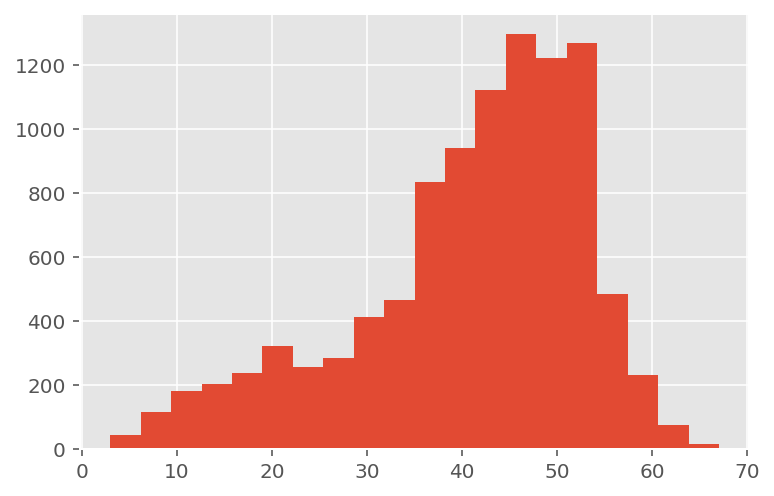

In [6]:
costs.sample(10000).cost.hist(bins=20);

In [7]:
X_raw = costs.iloc[:,:-1].values
y = costs['cost'].values

In [8]:
X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
class LearningRateFinderCallback(Callback):
    def __init__(self):
        self.lr = 0.00001
        self.learning_rates = list()
        self.losses = list()
    
    def on_train_batch_begin(self, batch, logs=None):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
        self.lr = self.lr * 1.1

    def on_train_batch_end(self, batch, logs=None):
        self.losses.append(logs["loss"])
        self.learning_rates.append(self.lr)

In [33]:
def asymmetric_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true) * K.square(K.sign(y_pred - y_true) + 0.6), axis=-1)

def get_model(layer_sizes, 
              learning_rate=0.001, 
              dropout_ratio=0.2, 
              activation='elu', 
              loss='mean_squared_error',
              kernel_initializer='he_normal', 
              batch_normalize=True):
    model = Sequential()
    model.add(Dense(layer_sizes[0], input_shape=(256,), activation=activation, kernel_initializer=kernel_initializer))
    model.add(Activation(activation))
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_ratio))
    
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, activation=activation, kernel_initializer=kernel_initializer))
        model.add(Activation(activation))
        if batch_normalize:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_ratio))

    model.add(Dense(1, kernel_initializer='he_normal'))
    model.compile(loss=loss,
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model

In [34]:
lr_finder = LearningRateFinderCallback()

model = get_model([1024, 1024, 512, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=1,
                    verbose=0,
                    callbacks=[lr_finder])

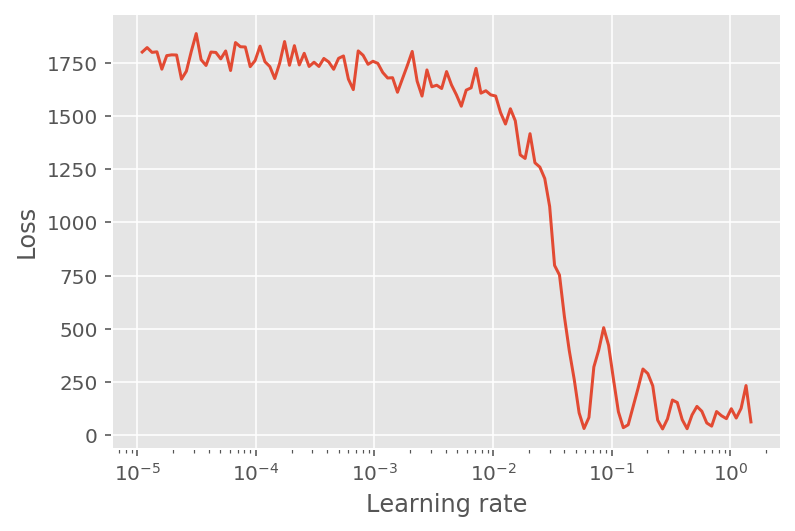

In [35]:
plt.plot(lr_finder.learning_rates, lr_finder.losses)
plt.xscale('log')
plt.xlabel("Learning rate")
plt.ylabel("Loss");

The best learning rate is about 0.03.